In [181]:
import warnings
warnings.filterwarnings('ignore')
from utils import general_utils
from utils import audio_utils
import importlib
importlib.reload(general_utils)
import pandas as pd
import models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import math


In [2]:
importlib.reload(audio_utils)
importlib.reload(general_utils)

<module 'utils.general_utils' from '/home/ec2-user/git/udacity_capstone/utils/general_utils.py'>

# Using Deep Neural Network to Predict Musical Instrument Family

Goal: Use the NSynth Dataset by Google Inc. data to train a deep neural net to label the instrument playing a single note at any pitch or velocity.

Instrument Families: Bass, Brass, Flute, Guitar, Keyboard, Mallet, Organ, Reed, String, Synth Lead, Vocal

Dataset: https://magenta.tensorflow.org/datasets/nsynth

Benchmark Model: Naive Predictor: Given the distribution of instrument samples (seen below), the chances of predicting any one instrument correctly at random are approximately 9.09%
<pre>
Instrument       Samples      Proportion of Dataset
Bass              68,955             22.54%
Brass             13,830              4.52%
Flute              9,423              3.08%
Guitar            35,423             11.58%
Keyboard          54,991             17.97%
Mallet            35,066             11.46%
Organ             36,577             11.95%
Reed              14,866              4.86%
String            20,594              6.73%
Synth Lead         5,501              1.80%
Vocal             10,753              3.51%
</pre>

## Steps

- Extract all the sound samples from the NSynth dataset and generate spectrogram jpegs for each
- Load the the spectograms into three labeled sets (training, validation, testing)
- Train on a number of different models
- Test model

## Inspect a tfrecord file's data

In [3]:
general_utils.list_data_in_tfrecord("data/nsynth-test.tfrecord",2)

W1003 01:47:54.681072 140184331016000 deprecation_wrapper.py:119] From /home/ec2-user/git/udacity_capstone/utils/general_utils.py:122: The name tf.enable_eager_execution is deprecated. Please use tf.compat.v1.enable_eager_execution instead.

W1003 01:47:54.682515 140184331016000 deprecation.py:323] From /home/ec2-user/git/udacity_capstone/utils/general_utils.py:125: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`



RECORD  1 

qualities
int64_list {
  value: 0
  value: 0
  value: 0
  value: 0
  value: 0
  value: 0
  value: 0
  value: 0
  value: 0
  value: 0
}

instrument_source_str
bytes_list {
  value: "synthetic"
}

audio
omitted

instrument
int64_list {
  value: 417
}

qualities_str
bytes_list {
}

note
int64_list {
  value: 149013
}

instrument_str
bytes_list {
  value: "bass_synthetic_033"
}

instrument_family_str
bytes_list {
  value: "bass"
}

velocity
int64_list {
  value: 100
}

pitch
int64_list {
  value: 100
}

instrument_family
int64_list {
  value: 0
}

note_str
bytes_list {
  value: "bass_synthetic_033-100-100"
}

sample_rate
int64_list {
  value: 16000
}

instrument_source
int64_list {
  value: 2
}


RECORD  2 

instrument
int64_list {
  value: 417
}

qualities_str
bytes_list {
}

note
int64_list {
  value: 155292
}

instrument_str
bytes_list {
  value: "bass_synthetic_033"
}

instrument_family_str
bytes_list {
  value: "bass"
}

velocity
int64_list {
  value: 127
}

pitch
int64_l

## Convert Sound Samples to Spectrogram Images

NOTE: Moved most of the logic for writing spectrograms is in the audio_utils library. Here's what it does:

1. Load the Tensorflow recordset (tfrecord file) with three specicific features we need: note_str, audio, and sample_rate).
 - note_str: name of the note (brass_acoustic_059-062-050)
 - audio: array of floats (samples)
 - sample_rate: samples per second
2. Use an asynchronous parallelized process to convert the sound files to spectograms in batches.
 - This function can:
 -  Write either mel scaled spectrograms or normally scaled spectrograms
 -  Overwrite files or not
 -  Use a regex filter to limit the dataset based on sound name patterns


In [4]:
test_spectrogram_folder = 'data/nsynth-test-mel-spectrograms-ac-060-072'
valid_spectrogram_folder = 'data/nsynth-valid-mel-spectrograms-ac-060-072'
train_spectrogram_folder = 'data/nsynth-train-mel-spectrograms-ac-060-072'

# Take only acoustic instruments between C4 (middle C) and C5. This correlates to MIDI numbers 60 to 72.
#regex_filter = None
regex_filter = '.*acoustic.*-0(6[0-9]|7[0-2])-.*'

In [5]:
importlib.reload(audio_utils)

### COMMENTED OUT TO MAKE SURE WE DON'T ACCIDENTALLY START THE PROCESS OF GOING THROUGH OVER 300K RECORDS

#audio_utils.write_spectograms_parallelized('data/nsynth-test.tfrecord', test_spectrogram_folder, 
#                                           batch_size=200, mel=True, overwrite=False, regex_filter=regex_filter)

#audio_utils.write_spectograms_parallelized('data/nsynth-valid.tfrecord', valid_spectrogram_folder, 
#                                           batch_size=200, mel=True, overwrite=False, regex_filter=regex_filter)

## following took about 4 or 5 hours with full dataset
#audio_utils.write_spectograms_parallelized('data/nsynth-train.tfrecord', train_spectrogram_folder, 
#                                           batch_size=200, mel=True, overwrite=False, regex_filter=regex_filter)

#output for full dataset was: "processed 289205 files out of 289205 in 1446 batches"

<module 'utils.audio_utils' from '/home/ec2-user/git/udacity_capstone/utils/audio_utils.py'>

## Load the datasets (files, targets, and names)

In [6]:
train_files, train_targets, train_target_names = general_utils.load_dataset(train_spectrogram_folder)

print('info about training set')
print('number of samples: ', len(train_files))
print('categories are: ', sorted(set(train_target_names)))
#print(train_files[500:501])
#print(train_targets[500:501])
#print(train_target_names[500:501])

valid_files, valid_targets, valid_target_names = general_utils.load_dataset(valid_spectrogram_folder)

print('\ninfo about validation set')
print('number of samples: ', len(valid_files))
print('categories are: ', sorted(set(valid_target_names)))
#print(valid_files[500:501])
#print(valid_targets[500:501])
#print(valid_target_names[500:501])

# load the test data
test_files, test_targets, test_target_names = general_utils.load_dataset(test_spectrogram_folder)

print('\ninfo about test set')
print('number of samples: ', len(test_files))
print('categories are: ', sorted(set(test_target_names)))
#print(test_files[500:501])
#print(test_targets[500:501])
#print(test_target_names[500:501])

info about training set
number of samples:  22376
categories are:  ['brass', 'flute', 'guitar', 'keyboard', 'mallet', 'reed', 'string', 'vocal']

info about validation set
number of samples:  942
categories are:  ['brass', 'flute', 'guitar', 'keyboard', 'mallet', 'reed', 'string', 'vocal']

info about test set
number of samples:  340
categories are:  ['brass', 'flute', 'guitar', 'keyboard', 'mallet', 'reed', 'string', 'vocal']


## Build dataframes
build dataframes that will be part of the image generator construction

### PART 1: zip the data

In [7]:
# merge the three arrays into an array of tupples
train_data = list(zip(train_files, train_targets, train_target_names))
valid_data = list(zip(valid_files, valid_targets, valid_target_names))
test_data = list(zip(test_files, test_targets, test_target_names))

### PART 2: Limit the size of the datasets if needed

In [8]:
# uncomment / change the code here

#train_data = train_data[:50000]
#valid_data = valid_data[:2150]
#test_data = test_data[:4096]

### PART 3: Create the dataframes

In [9]:
train_df = pd.DataFrame(train_data, columns = ['file_paths', 'targets', 'target_names'])
valid_df = pd.DataFrame(valid_data, columns = ['file_paths', 'targets', 'target_names'])
test_df = pd.DataFrame(test_data, columns = ['file_paths', 'targets', 'target_names'])

In [10]:
print('### train shape', train_df.shape)
print('### valid shape', valid_df.shape)
print('### test shape', test_df.shape)

### train shape (22376, 3)
### valid shape (942, 3)
### test shape (340, 3)


## Create the ImageDataGenerators

This Keras tool generates batches of tensor image data. It can augment the images as well, but for this project I have not used that feature as spectograms are not 'in the wild' as photographs tend to be. I would be interesting to experiment with this in a further iteration, however.

One generator for each of the three datasets.

In [32]:
# create the data generator
from keras_preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator()

In [33]:
# make the training data generator
train_generator = datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='file_paths',
        y_col='target_names',
        batch_size=20,
        seed=69,
        shuffle=True,
        class_mode='categorical',
        target_size=(21,20)
    )

Found 22376 images belonging to 8 classes.


In [34]:
# make the validation data generator
valid_generator = datagen.flow_from_dataframe(
        dataframe=valid_df,
        x_col='file_paths',
        y_col='target_names',
        batch_size=20,
        seed=69,
        shuffle=True,
        class_mode='categorical',
        target_size=(21,20)
    )

Found 942 images belonging to 8 classes.


In [35]:
# make the test data generator
test_generator = datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='file_paths',
        y_col='target_names',
        batch_size=20,
        seed=69,
        # NOTE: VERY important that shuffle be set to False or run_prediction won't be able to line up actual labels with predicted labels
        shuffle=False,
        class_mode='categorical',
        target_size=(21,20)
    )

Found 340 images belonging to 8 classes.


In [36]:
# USEFULL THINGS

#to go through all of the files to make sure they're findable
#import os.path
#for f in valid_files:#valid_generator.filepaths:
#    if not os.path.exists(f):
#        print(f, 'does not exist')

# get all of the file paths in the data generator
#generator_files = set(valid_generator.filepaths)

# make sure all of the actual files are accounted for in the generator
#i = 0
#for f in valid_files:
#    if f not in generator_files:
#        print('N', f)
#        i+=1
    #else:
        #print('Y', f)
#print(i, 'files do not match')

### Find the step sizes for each of the sets.

In [37]:
steps_train=train_generator.n//train_generator.batch_size #+ 1
steps_valid=valid_generator.n//valid_generator.batch_size #+ 1
steps_test=test_generator.n//test_generator.batch_size #+ 1
#STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
print('train_generator.n//train_generator.batch_size is {}//{}'.format(train_generator.n, train_generator.batch_size))
print('valid_generator.n//valid_generator.batch_size is {}//{}'.format(valid_generator.n, valid_generator.batch_size))
print('test_generator.n//test_generator.batch_size is {}//{}'.format(test_generator.n, test_generator.batch_size))
print('train step size: {}, validation step size: {}, test step size: {}'.format(steps_train, steps_valid, steps_test))

train_generator.n//train_generator.batch_size is 22376//20
valid_generator.n//valid_generator.batch_size is 942//20
test_generator.n//test_generator.batch_size is 340//20
train step size: 1118, validation step size: 47, test step size: 17


## Run models

This cell is reused for each tested model. The models are all added to the 'models' library and labeled with a number. See the noted results of each model in the library.

In [38]:
importlib.reload(models)

# Save the checkpoints to here. Make sure the file name reflects the model version.
model_hdf5 = 'saved_models/weights.best.v15_1.hdf5'

# Use the same model for each of the steps below. See 'models.py' for details.
model_creator = models.create_model_v15

# Create the model to train
train_model = model_creator(show_summary=True)

epochs = 20

# Set this to True to continue training the model if you need more epochs or
# . to start on a specific epoch if the training is interrupted and you want to continue
if False:
    initial_epoch=0
    train_model.load_weights(model_hdf5)
else:
    initial_epoch=0

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 21, 20, 32)        6176      
_________________________________________________________________
activation_72 (Activation)   (None, 21, 20, 32)        0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 14, 13, 64)        131136    
_________________________________________________________________
activation_73 (Activation)   (None, 14, 13, 64)        0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 14, 13, 64)        0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 14, 13, 64)        36928     
_________________________________________________________________
activation_74 (Activation)   (None, 14, 13, 64)       

In [39]:
importlib.reload(models)

checkpointer = ModelCheckpoint(filepath=model_hdf5, 
                               verbose=1, save_best_only=True)

# End trining if there's no improvement in four epochs.
early_stopper = EarlyStopping(monitor='categorical_accuracy', 
                              #mode='min', 
                              verbose=1, patience=6)


train_model.fit_generator(generator=train_generator,
                          steps_per_epoch=steps_train,
                          validation_data=valid_generator,
                          validation_steps=steps_valid,
                          epochs=epochs,
                          callbacks=[checkpointer,early_stopper],
                          workers=4,
                          initial_epoch=initial_epoch
)

r_trained_orig = train_model.evaluate_generator(generator=valid_generator, steps=steps_valid)

Epoch 1/20
1115/1118 [============================>.] - ETA: 0s - loss: 1.1005 - categorical_accuracy: 0.6041
Epoch 00001: val_loss improved from inf to 1.24997, saving model to saved_models/weights.best.v15_1.hdf5
1118/1118 [==============================] - 59s 52ms/step - loss: 1.1000 - categorical_accuracy: 0.6044 - val_loss: 1.2500 - val_categorical_accuracy: 0.5755
Epoch 2/20
1115/1118 [============================>.] - ETA: 0s - loss: 0.6706 - categorical_accuracy: 0.7750
Epoch 00002: val_loss improved from 1.24997 to 1.14834, saving model to saved_models/weights.best.v15_1.hdf5
1118/1118 [==============================] - 55s 50ms/step - loss: 0.6713 - categorical_accuracy: 0.7749 - val_loss: 1.1483 - val_categorical_accuracy: 0.6553
Epoch 3/20
1117/1118 [============================>.] - ETA: 0s - loss: 0.5969 - categorical_accuracy: 0.8036
Epoch 00003: val_loss did not improve from 1.14834
1118/1118 [==============================] - 56s 50ms/step - loss: 0.5966 - categorical

# Convolution Layer Visualizations

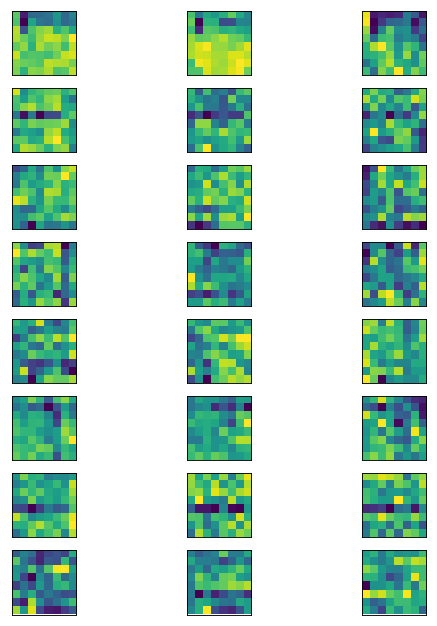

In [55]:
## Visualizations of the model filters

importlib.reload(general_utils)
importlib.reload(models)

#general_utils.print_model_conv_layers(model)
general_utils.visualize_model_filters(train_model, layer_number=0, n_filters=8, size=50)

# Results

NOTE: The results below are ONLY for the most recently tested model.

<b> Please see the `models.py` file for all of the models and the results for each.</b>

## Loss and Categorical Accuracy of the Newly Trained Model


NOTE: This is the model that was just trained and includes the latest epoches that were not saved as best in the checkpoint

Later when the checkpoint is loaded, the best scores will be reflected.

In [47]:
# print loss and categorical accuracy


r_trained_orig = train_model.evaluate_generator(generator=valid_generator, steps=steps_valid)
print('## Loss: ', r_trained_orig[0], ' Categorical Accuracy: ', r_trained_orig[1])

## Loss:  2.332265515276726  Categorical Accuracy:  0.5170213


## Total validation records: 942
## Number of correct: 159
## Percent correct: 0.16878980891719744


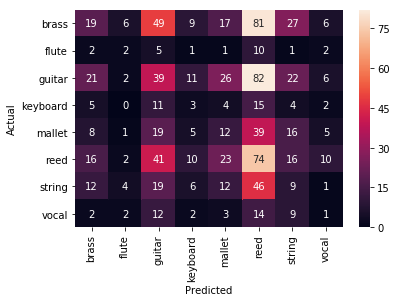

In [49]:
# Testing the trained model on the validation data

## NOTE: This is the model that was just trained and includes the latest epoches that 
##       were not saved as best in the checkpoint
## Later when the checkpoint is loaded, better results will be reflected.

importlib.reload(general_utils)

results, y_predicted, y_actual = general_utils.run_prediction(train_model, valid_generator)

num_trained_valid_correct = np.count_nonzero(results)
print('## Total validation records:', len(results))
print('## Number of correct:', num_trained_valid_correct)
print('## Percent correct:', num_trained_valid_correct/len(results))

data_labels_dict = general_utils.get_label_dict_from_generator(valid_generator)
general_utils.display_confusion(y_predicted, y_actual, data_labels_dict)

## Evaluation of Untrained Model
### Loss and Categorical Accuracy

This is a test to see the difference between the untrained and trained versions of the same model

In [50]:
# test untrained model
untrained_test_model = model_creator()

score_untrained = untrained_test_model.evaluate_generator(test_generator, steps=steps_test)
print('## Loss: ', score_untrained[0], ' Accuracy: ', score_untrained[1])

#for i, n in enumerate(test_generator.filenames):
#    print('file:', n, ' score: ', scores[i][0])


## Loss:  2.0836836099624634  Accuracy:  0.15


### Prediction of the untrained model

## Total test records: 340
## Number of correct: 51
## Percent correct: 0.15


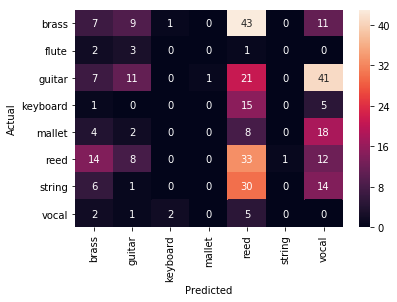

In [51]:
## Testing the untrained model
importlib.reload(general_utils)

results, y_predicted, y_actual = general_utils.run_prediction(untrained_test_model, test_generator)

num_untrained_test_correct = np.count_nonzero(results)

print('## Total test records:', len(results))
print('## Number of correct:', num_untrained_test_correct)
print('## Percent correct:', num_untrained_test_correct/len(results))

data_labels_dict = general_utils.get_label_dict_from_generator(test_generator)
general_utils.display_confusion(y_predicted, y_actual, data_labels_dict)

## Evaluation of Trained Model
### Loss and Accuracy

In [73]:
# next test the trained model
trained_test_model = model_creator()
print('Loading checkpoint: ', model_hdf5)
trained_test_model.load_weights(model_hdf5)

score_trained = trained_test_model.evaluate_generator(test_generator, steps=steps_test)
print('## Loss: ', score_trained[0], ' Categorical Accuracy: ', score_trained[1])

Loading checkpoint:  saved_models/weights.best.v15_1.hdf5
## Loss:  0.9298041936229257  Categorical Accuracy:  0.7352941


### Prediction of the Trained model

## Total test records: 340
## Number of correct: 250
## Percent correct: 0.7352941176470589


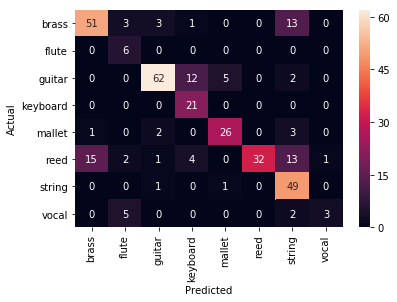

In [74]:
## Testing the trained model
importlib.reload(general_utils)

results, y_predicted, y_actual = general_utils.run_prediction(trained_test_model, test_generator)

num_trained_test_correct = np.count_nonzero(results)
print('## Total test records:', len(results))
print('## Number of correct:', num_trained_test_correct)
print('## Percent correct:', num_trained_test_correct/len(results))

data_labels_dict = general_utils.get_label_dict_from_generator(test_generator)
general_utils.display_confusion(y_predicted, y_actual, data_labels_dict)

## Visualize Feature Maps for a Sample Spectrogram

In [87]:
# find the convolutional layer numbers
importlib.reload(general_utils)

general_utils.print_model_conv_layers(trained_test_model, conv_only=True)

layer 0 conv2d_91 (8, 8, 3, 32)
layer 2 conv2d_92 (8, 8, 32, 64)
layer 5 conv2d_93 (3, 3, 64, 64)
layer 7 conv2d_94 (3, 3, 64, 64)
layer 9 conv2d_95 (3, 3, 64, 64)
layer 12 conv2d_96 (3, 3, 64, 128)
layer 14 conv2d_97 (3, 3, 128, 128)


In [132]:
importlib.reload(models)

# get the output model
layer_indexes = [0, 2, 5, 7, 9, 12, 14]

output_model = models.create_output_model(trained_test_model, layer_indexes)

output layers
- Tensor("conv2d_91/Identity:0", shape=(?, 21, 20, 32), dtype=float32)
- Tensor("conv2d_92/Identity:0", shape=(?, 14, 13, 64), dtype=float32)
- Tensor("conv2d_93/Identity:0", shape=(?, 14, 13, 64), dtype=float32)
- Tensor("conv2d_94/Identity:0", shape=(?, 12, 11, 64), dtype=float32)
- Tensor("conv2d_95/Identity:0", shape=(?, 10, 9, 64), dtype=float32)
- Tensor("conv2d_96/Identity:0", shape=(?, 10, 9, 128), dtype=float32)
- Tensor("conv2d_97/Identity:0", shape=(?, 8, 7, 128), dtype=float32)


<class 'PIL.Image.Image'>
None
RGB
(20, 21)
num_filters 32


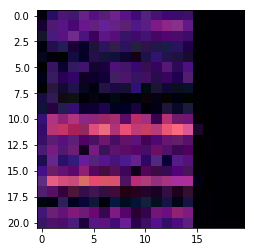

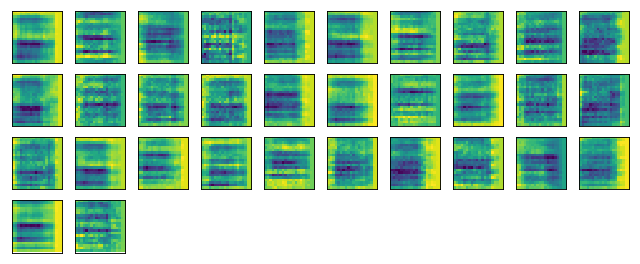

num_filters 64


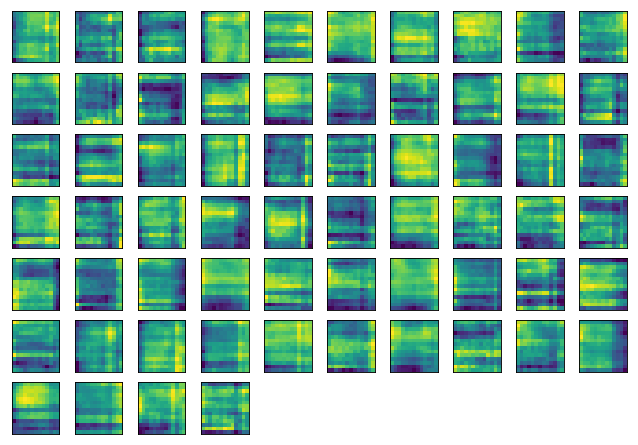

num_filters 64


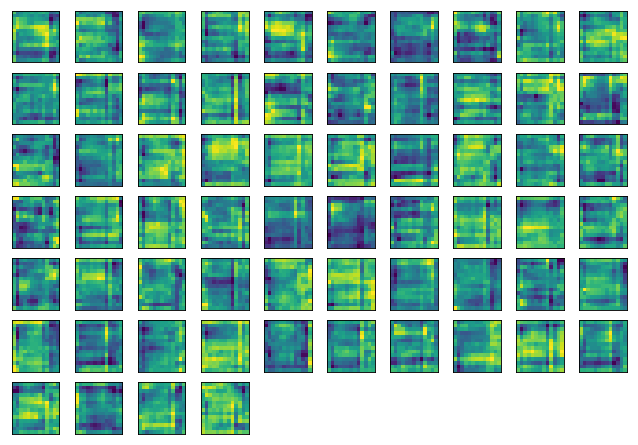

num_filters 64


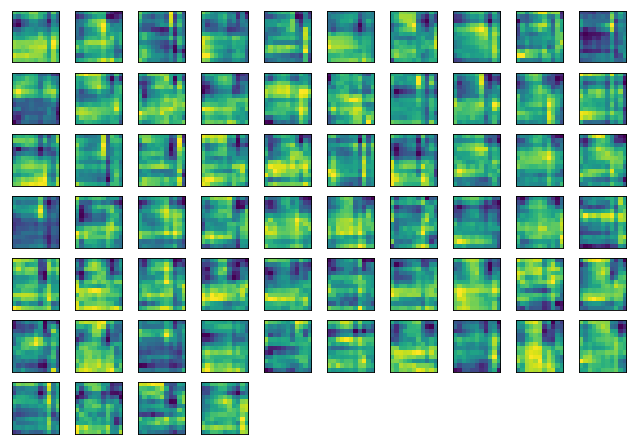

num_filters 64


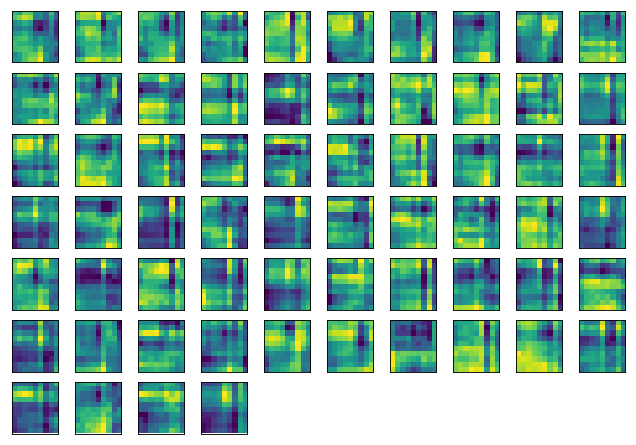

num_filters 128


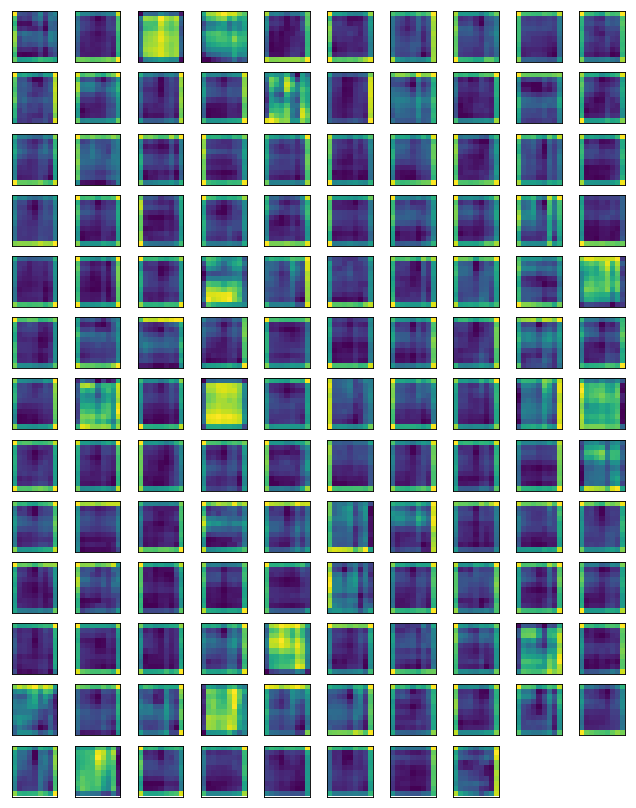

num_filters 128


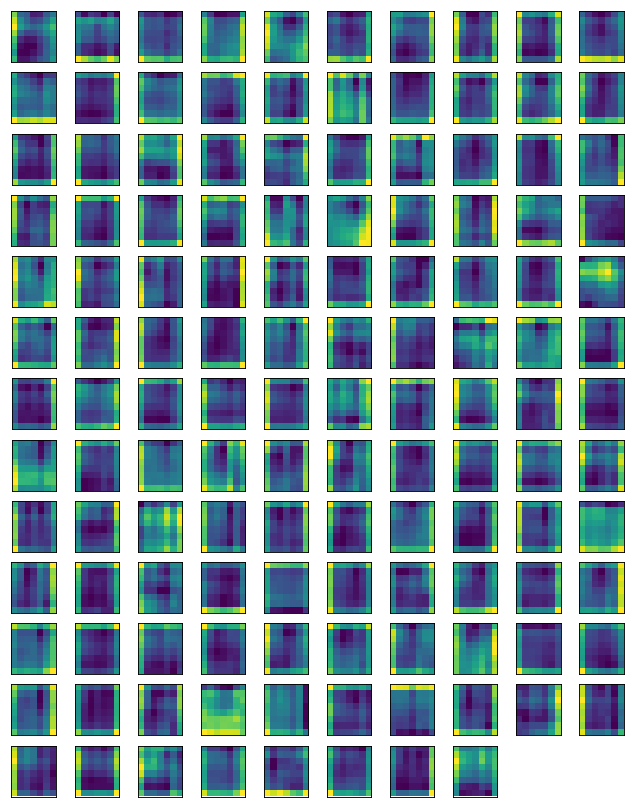

In [188]:
# load test image
from keras.preprocessing import image
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
img = image.load_img('data/nsynth-test-spectrograms/vocal/vocal_acoustic_000-064-075.jpg', target_size=(21, 20))

print(type(img))
print(img.format)
print(img.mode)
print(img.size)

# need this to display because the Keras img_to_array method converts the array to floats 
#  and imshow doesn't display that properly
img_to_display = np.asarray(img)
imshow(img_to_display)

img_for_model = image.img_to_array(img)

# make it fit to a sample shape
img_for_model = np.expand_dims(img_for_model, axis=0)

# and scale the image
img_for_model /= 255.

# get the feature maps
feature_maps = output_model.predict(img_for_model)

# print out the feature maps

columns = 10
for fm in feature_maps:
    num_filters = np.size(fm,3)
    print('num_filters', num_filters)
    rows = math.ceil(num_filters / columns)
    plt.figure(num=None, figsize=(columns, rows), dpi=80)
    ind = 1
    for _ in range(columns):
        while True:
            if ind == num_filters + 1:
                break
            axs = plt.subplot(rows, columns, ind)
            axs.set_xticks([])
            axs.set_yticks([])
            plt.imshow(fm[0, :, :, ind-1])
            ind += 1
    plt.show()
    plt.close()